# Denoising Images with a U-Net

In this task will train a U-Net for image denoising using PyTorch. As dataset, we use the Berkeley Segmentation Dataset (BSDS300). This dataset contains 300 clean color images. For simplicity, we consider Gaussian noise and convert the images to grayscale (see below). The attached file `unet.py` contains a PyTorch implemenation of the U-Net for you to use.

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import tqdm  # for nice progress bars
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch
from unet import Unet # This file was downloaded from: https://github.com/facebookresearch/fastMRI/blob/main/fastmri/models/unet.py


Unzip BSDS300 dataset in local path.

In [2]:
import zipfile
import os

path = os.getcwd()
f = zipfile.ZipFile("./BSDS300.zip",'r') 
for file in f.namelist():
    f.extract(file,path)
f.close


<bound method ZipFile.close of <zipfile.ZipFile filename='./BSDS300.zip' mode='r'>>

We use all 200 images in `./BSDS300/images/train` for training. The first 50 images in `./BSDS300/images/test` are used for validation and the remaining 50 for testing.

In [3]:
dataset_dir = "./BSDS300"
train_set_dir = f"{dataset_dir}/images/train"
train_img_files = [f"{train_set_dir}/{filename}" for filename in os.listdir(train_set_dir)]

test_set_dir = f"{dataset_dir}/images/test"
test_img_files = [f"{test_set_dir}/{filename}" for filename in os.listdir(test_set_dir)]
val_img_files = test_img_files[:50]
test_img_files = test_img_files[50:]

## Data preprossing
 The data preprocessing steps for creating a dataset. It involves converting RGB images to grayscale, scaling pixel values, adding Gaussian noise, and dividing images into non-overlapping chunks. The goal is to generate pairs of noisy and clean images for training a model.

 1. Implement a `torch.utils.data.Dataset` that generates pairs of noisy images and clean ground truth.
 2. Convert the images from the BSDS dataset (which are RGB) to **grayscale**.
 3. Scale the pixel values of the grayscale images to the range of $[0, 1]$.
 4. Add zero-mean Gaussian noise to the clean images. The variance of the noise is specified as `noise_var`.
 5. To reduce computational cost, the images are divided into non-overlapping chunks of a specified size `(chunk_size x chunk_size)`.
 6. If the dimensions of the image are not divisible by chunk_size, the image is cropped until it becomes divisible. For example, an image of size $(512, 512)$ would be split into 16 non-overlapping chunks of size $(128, 128)$.
 7. The final result is a dataset containing multiple chunks derived from each original image. For instance, if there are 200 train images and each is split into $(128, 128)$ chunks, the dataset would consist of 1200 chunks in total.

In [4]:
class NoisyImageChunkDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_clean, self.chunks_noisy = self.get_clean_and_noisy_chunks()


    def get_clean_and_noisy_chunks(self):

        clean_images = [self.imags_convert(img) for img in self.img_files]
        chunks_clean = []
        chunks_noisy = []
        for clean_image in clean_images:
            width, height = np.shape(clean_image)
            num_chunks_x = width //self.chunk_size
            num_chunks_y = height //self.chunk_size     
            # Crop the image dimensions to be divisible by chunk_size
            width1 = num_chunks_y * self.chunk_size
            height1 = num_chunks_x * self.chunk_size
            clean_image1 = clean_image[:height1, :width1]
            # Add random noise to clean pictures
            noise = np.random.normal(0, np.sqrt(self.noise_var), clean_image1.shape)
            noisy_image = clean_image1 + noise        
            # Crop the image
            for i in range(num_chunks_y):
                for j in range(num_chunks_x):
                    left = j * self.chunk_size
                    upper = i * self.chunk_size
                    right = (j + 1) * self.chunk_size
                    lower = (i + 1) * self.chunk_size
                    chunk_clean = clean_image1[left:right, upper:lower] 
                    chunks_clean.append(chunk_clean)
                    chunk_noisy = noisy_image[left:right, upper:lower]
                    chunks_noisy.append(chunk_noisy)
                                
        return chunks_clean, chunks_noisy

    def imags_convert(self,img):
        clean_image1 = Image.open(img).convert("L")  # Convert to grayscale
        clean_image2 = np.array(clean_image1) / 255.0 # Normilze the image  
        return clean_image2

    def __len__(self):
        return len(self.chunks_clean)

    def __getitem__(self, idx):
        return self.chunks_noisy[idx], self.chunks_clean[idx]

Add the Gaussian noise with zero-mean and variance $0.005$. Convert the images to chunks with size $(128, 128)$.
Then the shape of train_set is $(1200, 2, 128, 128)$;
shape of val_set and test_set are $(300, 2, 128, 128)$.

In [5]:
noise_var = 0.005  
chunk_size = 128  
train_set = NoisyImageChunkDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=chunk_size)
val_set = NoisyImageChunkDataset(img_files=val_img_files, noise_var=noise_var, chunk_size=chunk_size)
test_set = NoisyImageChunkDataset(img_files=test_img_files, noise_var=noise_var, chunk_size=chunk_size)


Visualize chunk images

First image is a chunk of noise image
Second image is a chunk of clean image


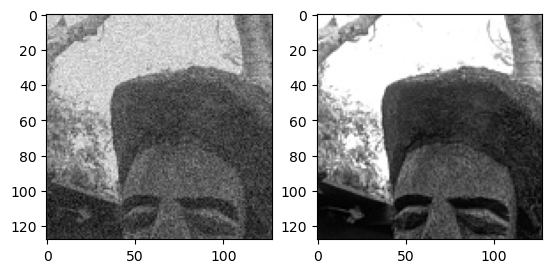

In [6]:
    plt.subplot(1, 2, 1)
    plt.imshow(val_set[0][0], cmap="gray")
    print('First image is a chunk of noise image')

    plt.subplot(1, 2, 2)
    plt.imshow(val_set[0][1], cmap="gray")
    print('Second image is a chunk of clean image')


In [7]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model Training and validation

Set the parameter of model.

In [8]:
batch_size = 16 
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

num_pool_layers = 2
chans = 16
device = "cuda"  

model = Unet(
    in_chans=1,  # 1 input channel as we use grayscale images as input
    out_chans=1,  # 1 output channel as the model returns grayscale images
    num_pool_layers=num_pool_layers,
    chans=chans
)
model = model.to(device,dtype=torch.float64)

Define the PSNR function to check the model whether or not overfit.

In [9]:

def calculate_psnr(original, denoised):
    # Ensure that the images have the same shape and data type
    assert original.shape == denoised.shape, "Original and reconstructed images must have the same shape"
    assert original.dtype == denoised.dtype, "Original and reconstructed images must have the same data type"
    # Scale the pixel values to the range [0, 1]
    original = original.clamp(0,1)
    denoised = denoised.clamp(0,1)

    # Calculate the mean squared error (MSE)
    mse_loss = nn.MSELoss()
    mse = mse_loss(denoised, original)

    # Maximum pixel value is 1.0
    # Calculate the PSNR using the formula: PSNR = - 10 * log10(MSE)
    psnr = - 10 * torch.log10(mse)

    return psnr

In [10]:
# choose a suitable optimizer form torch.optim; we recommend to use the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4) 
criterion = nn.MSELoss()
criterion.to(device)
# Define number of epochs and validation interval
epochs = 10
check_val_every_epochs = 1

# Training loop
for e in range(epochs):
    model.train()
    train_loss = 0.0
    for imgs_noisy, imgs_clean in tqdm.tqdm(train_loader, desc="Training"):
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)

        # Normalize the images
        mean, std = imgs_noisy.mean(), imgs_noisy.std()
        imgs_noisy = (imgs_noisy - mean) / std
        imgs_clean = torch.unsqueeze(imgs_clean, 1)
        imgs_noisy = torch.unsqueeze(imgs_noisy, 1)

        # Denoising
        img_denoised = model(imgs_noisy)
        img_denoised = img_denoised * std + mean
        loss = criterion(img_denoised, imgs_clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train loss
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {e+1}/{epochs}, Training Loss: {train_loss:.4f}")

    if e % check_val_every_epochs == 0:
        model.eval()  # Set model to evaluation mode
        val_psnr = 0.0
        
        # Disable gradient computation for validation
        with torch.no_grad():
            for imgs_noisy, imgs_clean in tqdm.tqdm(val_loader, desc="Validation"):
                imgs_noisy = imgs_noisy.to(device)
                imgs_clean = imgs_clean.to(device)
                N = len(imgs_clean)
                # Normalize the images
                mean, std = imgs_noisy.mean(), imgs_noisy.std()
                imgs_noisy = (imgs_noisy - mean) / std
                imgs_clean = torch.unsqueeze(imgs_clean, 1)
                imgs_noisy = torch.unsqueeze(imgs_noisy, 1)
                # Denoising
                imgs_denoised = model(imgs_noisy)
                imgs_denoised = imgs_denoised * std + mean

                # Calculate PSNR
                psnr = calculate_psnr(imgs_clean, imgs_denoised)
                val_psnr += psnr.item()
        val_psnr /= len(val_loader)
        print(f'Validation PSNR: {val_psnr:.2f}')


Training: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Epoch 1/10, Training Loss: 0.0245


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Validation PSNR: 16.72


Training: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


Epoch 2/10, Training Loss: 0.0205


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


Validation PSNR: 17.01


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 3/10, Training Loss: 0.0190


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Validation PSNR: 17.48


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 4/10, Training Loss: 0.0175


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Validation PSNR: 17.89


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 5/10, Training Loss: 0.0163


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


Validation PSNR: 18.21


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 6/10, Training Loss: 0.0141


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


Validation PSNR: 18.72


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 7/10, Training Loss: 0.0108


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Validation PSNR: 19.78


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 8/10, Training Loss: 0.0088


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


Validation PSNR: 20.36


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 9/10, Training Loss: 0.0075


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


Validation PSNR: 20.74


Training: 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 10/10, Training Loss: 0.0066


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]

Validation PSNR: 21.26


## Test model

In [11]:

# Evaluate the model on the test dataset
test_psnr = 0.0
base_psnr = 0.0


with torch.no_grad():
    for imgs_noisy, imgs_clean in test_loader:
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)

        # Normalize the images
        mean, std = imgs_noisy.mean(), imgs_noisy.std()
        imgs_noisy = (imgs_noisy - mean) / std
        imgs_clean = torch.unsqueeze(imgs_clean, 1)
        imgs_noisy = torch.unsqueeze(imgs_noisy, 1)
        # Denoising
        imgs_denoised = model(imgs_noisy)
        imgs_denoised = imgs_denoised * std + mean

        test_psnr += calculate_psnr(imgs_clean, imgs_denoised)
        base_psnr += calculate_psnr(imgs_clean, imgs_noisy)
    test_psnr /= len(test_loader)
    base_psnr /= len(test_loader)
    print(f"PSNR of noisy images: {base_psnr:.2f}")
    print(f'PSNR of denoised images: {test_psnr:.2f}')

PSNR of noisy images: 10.99
PSNR of denoised images: 21.53
